# Imports

In [791]:
%matplotlib inline
import sys
import pandas as pd
import math
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib as mpl
from collections import Counter
import numpy as np
import subprocess
import re
import itertools
import mmh3
import random
import json
import pickle
from datetime import datetime as dt
from datetime import time
from random import randrange, gauss, shuffle
import networkx as nx
import community
from collections import defaultdict
from datetime import datetime as dt
from scipy.sparse import csr_matrix
from scipy.sparse import triu
import scipy
from dateutil import tz
import datetime
from scipy.optimize import curve_fit
from random import choice, sample
from shapely.geometry import Polygon
import mahotas
from ulf import ulf
reload(ulf)

<module 'ulf.ulf' from '/usr/local/lib/python2.7/site-packages/ulf/ulf.pyc'>

# Functions

## Project specific

In [2]:
def load_binned_network(kind, filename):
    with open('data/processed_data/binned_networks/'+kind+'/'+filename+'.pkl', 'r') as infile:
        return pickle.load(infile)
    
def build_adjacency_tensor(layers, index="zero"):
    nodes = set([
        n
        for l in layers
        for n in list(l['user1']) + list(l['user2'])
    ])
    
    ind = dict((n, i) for i, n in enumerate(nodes))
    
    A = defaultdict(int)
    for l, layer in enumerate(layers):
        for _, row in layer.iterrows():
            # Must add both ways if undirected so A becomes symmetrical. If only added one-way
            # triu will only be connections from 'user' and and tril from 'bt_mac' or vice versa.
            if index == "zero":
                A[(ind[row['user1']], ind[row['user2']], l)] += 1
                A[(ind[row['user2']], ind[row['user1']], l)] += 1
            else:
                A[(row['user1'], row['user2'], l)] += 1
                A[(row['user2'], row['user1'], l)] += 1
    return A

In [3]:
def write_pajek(A, node_labels=None, index_from=0):
    """Return multiplex representation of multiplex network adjacency matrix A
    
    Providing an adjacency tensor where A[:, :, k] is adjacency matrix of temporal
    layer k, return a pajek format representation of the temporal network which weights interlayer
    edges by state node neighborhood similarity. 
    
    Parameters
    ----------
    A : numpy.3darray
        3d tensor where each A[:, :, k] is a layer adjacency matrix
    max_trans_prob : float/str
        Cap on interlayer edge weights. 'square' for square penalty.
    power_penalty : int/float
        Power to jaccard similarity betw. state nodes to penalize low similarity
    index_from : int
        From which number to index nodes and layers in pajek format from
    style : bool
        Either 'zigzag', 'vertical', or 'simple'. 'vertical' will give working results but is
        essentially wrong use of Infomap, 'simple' should be possible to use in Infomap but is not
        at this point, so 'zigzag' is preferred because it is an explicit representation of the way
        the network should be represented internally in Infomap.

    Returns
    -------
    out_file : string
        A network string in multiplex format
    intid_to_origid : dict
        Key-value pairs of node integer id and original id
    origid_to_intid : dict
        Reverse of intid_to_origid
    """
    
    def _write_outfile(A):
        """Write nodes and intra/inter-edges from A and J to string."""
        def __remove_symmetry_A(A):
            A_triu = defaultdict(int)
            for (i, j, k), w in A.items():
                if j > i:
                    A_triu[(i, j, k)] = w
            return A_triu
        def __write_nodes(outfile):
            outfile += "*Vertices %d" % Nn
            for nid, label in enumerate(nodes):
                outfile += '\n%d "%s" 1.0' % (nid + index_from, str(label))
            return outfile
        def __write_intra_edges(outfile):
            outfile += "\n*Intra\n# layer node node [weight]"
            for (i, j, k), w in __remove_symmetry_A(A).items():
                outfile += '\n%d %d %d %f' % (
                    k + index_from,  # layer
                    nodemap[i] + index_from,  # node
                    nodemap[j] + index_from,  # node
                    w                # weight
                )
            return outfile
        
        outfile = ""
        outfile = __write_nodes(outfile)
        outfile = __write_intra_edges(outfile)
        
        return outfile
    
    nodes = sorted(set([n for i, j, _ in A.keys() for n in [i, j]]))
    Nn = len(nodes)
    Nl = len(set([k for i, j, k in A.keys()]))
    
    nodemap = dict(zip(nodes, range(Nn)))

    return _write_outfile(A)

In [4]:
def Infomap(pajek_string, *args):
    """Run multiplex community detection because Python implementation has no docs
    
    Parameters
    ----------
    pajek_string : pajek representation of the network (str)
    
    Returns
    -------
    communities : list of lists
    d3_ready : data structure in required format for d3 viz (json)
    """
    
    def _get_id_to_label(filename):
        with open('output/' + filename + ".net", 'r') as fp:
            parsed_network = fp.read()
        return dict(
            (int(n.split()[0]), n.split('"')[1])
            for n in parsed_network.split("\n*multiplex")[0].split("\n")[1:]
        )
    
    def _parse_communities(id_to_label):
        with open('output/'+pajek_filename+"_expanded.clu", 'r') as infile:
            clusters = infile.read()

        # Get layers, nodes and clusters from _extended.clu file
        la_no_clu = re.findall(r'\d+ \d+ \d+ \d\.\d+', clusters) # ["30 1 2 0.00800543",...]
        la_no_clu = [tuple(i.split()) for i in la_no_clu]

        communities_json = defaultdict(set)
        for layer, node, cluster, _ in la_no_clu:
            communities_json[int(layer)].add((id_to_label[int(node)], int(cluster)))

        return communities_json
    
    # Get network in multiplex string format and define filename
    pajek_filename = 'tmpnet'

    # Store locally
    with open("input/"+pajek_filename+".net", 'w') as outfile:
        outfile.write(pajek_string)
    
    # Run Infomap for multiplex network
    subprocess.call(
        ['./infomap/Infomap', 'input/'+pajek_filename+".net"] + \
        list(args)
    )
    
    # Parse communities from Infomap output
    id_to_label = _get_id_to_label(pajek_filename)
    parsed_communities = _parse_communities(id_to_label)

    orig_clu = [item for sublist in parsed_communities.values() for item in sublist]
    communities = dict()
    for key, group in itertools.groupby(orig_clu, lambda x: x[1]):
        for thing in group:
            try:
                communities[key].append(thing[0])
            except KeyError:
                communities[thing[1]] = [thing[0]]
    communities = dict((k,set(v)) for k,v in communities.items())

    d3_ready = {}
    for layer, group in parsed_communities.items():
        layer_communities = {}
        for no, clu in group:
            try:
                layer_communities[clu].append(no)
            except KeyError:
                layer_communities[clu] = [no]
        d3_ready[layer] = layer_communities

    return communities, d3_ready

## General

In [23]:
def naive(arr, stat):
    try:
        return stat(arr)
    except ValueError:
        return -1

# Load data

## Sensible DTU

**Load network**

In [5]:
network = load_binned_network('1month_data_new','5mins_short_new'); fof = 1

**Extract layers and make adjacency tensor**

In [77]:
# Make slices for each consequetive weekday (e.g. every monday)
spd = 288 / fof  # slices per day
dow = 0
days = 4
layers = [
    l
    for d in range(0, days*7,7)
    for l in network[spd*(dow+5+d):spd*(dow+6+d)]
]
A = build_adjacency_tensor(layers)

In [6]:
# Make slices for a span of days (e.g. monday to friday)
spd = 288 / fof  # slices per day
dow = 0
days = 7
layers = [
    l
    for d in range(0, days)
    for l in network[spd*(dow+5+d):spd*(dow+6+d)]
]
A = build_adjacency_tensor(layers)

## Primary school

In [113]:
network = pd.read_csv("data/primary_school/primaryschool.csv", delimiter="\t", names=["timestamp", 'user1', 'user2', 'class1', 'class2'])

In [ ]:
layers = [
    l for l 
]

# Analysis

**Format to pajek string**

In [7]:
network_pajek = write_pajek(A)

**Run Infomap community detection**

In [314]:
communities, layer_communities = Infomap(
    network_pajek,
    'output/',
    '-i',
    'multiplex',
    '--multiplex-js-relax-rate', '0.25',
    '--overlapping',
    '--expanded',
    '--clu',
    '--pajek',
    '--two-level',
    '-z'
)

In [315]:
print "Number of communities:", len(communities)

Number of communities: 938


# Save for visualisation

## Meta parameters

In [316]:
def compute_similarity_matrix(communities):
    def _get_similarity(i,j,communities, count=False):
        """communities : Communities in each layer"""
        sim_counter = len(communities[i] & communities[j])
        tot_counter = len(communities[i] | communities[j])

        if count:
            return sim_counter / float(tot_counter), sim_counter
        else:
            return sim_counter / float(tot_counter)
    dim = len(communities)
    X = {}
    for i in range(dim):
        for j in range(dim):
            sim, count = _get_similarity(i+1,j+1,communities, count=True)
            try:
                X['c'+str(i+1)].update({'c'+str(j+1): {'sim': sim, 'count': count}})
            except KeyError:
                X['c'+str(i+1)] = {'c'+str(j+1): {'sim': sim, 'count': count}}
    return X

def is_valid_location(new_block, existing_blocks, pad=5):
    """Check whether random horizontal location for block is unoccupied"""
    nb_x = new_block['x']
    nb_w = new_block['w']
    nb_range = set(range(int(nb_x-pad),int(nb_x+nb_w+pad)))
    for block in existing_blocks:
        eb_x = block['x']
        eb_w = block['w']
        eb_range = set(range(int(eb_x-pad),int(eb_x+eb_w+pad)))
        if len(nb_range & eb_range) != 0:
            return False

    return True
    
# Canvas parameters
#actual_width = max([len([n for l in layer_communities[k].values() for n in l])+5*len(layer_communities[k].values()) for k in layer_communities.keys()])
actual_height = len(layers)

min_group_size = 0

# Set working width and height
#width = actual_width*2
height = actual_height


#------#
# Time #
#------#

layers_concat = pd.concat(layers)

# Start, termination, timestep variables
#t0 = layers_concat['timestamp'].min() # 2014-02-03 00:05:00
#tt = layers_concat['timestamp'].max() # 2014-02-04 00:00:00
t0 = dt.combine(layers_concat['timestamp'].min().date(), dt.min.time())
tt = dt.combine(layers_concat['timestamp'].max(), dt.max.time())

d_t = str(5*fof) # 5 (minutes)

thickness = 300 * fof  # 300 (seconds)

# Lines marking important points in time
grid_times = [time(h) for h in [8,12,13,17]]
grid_ticks = dict(
    (i+1, str(t0 + datetime.timedelta(seconds=thickness*(i+1))))
    for i, l in enumerate(layers) 
    if (t0 + datetime.timedelta(seconds=thickness*(i+1))).time() in grid_times
)

# Time tick labels
label_times = [time(h) for h in range(24)]
label_ticks = dict(
    (i+1, str(t0 + datetime.timedelta(seconds=thickness*(i+1))))
    for i, _ in enumerate(layers) 
    if (t0 + datetime.timedelta(seconds=thickness*(i+1))).time() in label_times
)


## Initiate d3-dataset

In [516]:
#----------------------#
# Build data structure #
#----------------------#

# Initiate data structure
ds = {}

# Meta
ds['meta'] = {'w': width, 'h': height}

# Time
ds['time'] = {
    't0': str(t0),
    'tt': str(tt),
    'dt': d_t,
    'ticks': {
        'label_ticks': label_ticks,
        'grid_ticks': grid_ticks
    }
}

# Community similarities
ds['sims'] = compute_similarity_matrix(communities)

# Initiate communities and layer networks
ds['coms'] = {}
ds['layer_networks'] = {}

## Fill in communities

### Version 1

In [ ]:
# Compute geometry and location of community blocks
preferred_locations = {}
prev_layer_blocks = {}
for l, coms in layer_communities.items():
    # Community-size pairs
    com_size_pairs = [(k, len(v)) for k,v in coms.items() if len(v) >= min_group_size]
    
    # Compute blocks also in previous layer (EXISTING BLOCKS)
    this_layer_blocks = {}
    not_in_prev = []
    for c, s in com_size_pairs:
        
        com = "c"+str(c)
        if com in prev_layer_blocks:
            prev_block = prev_layer_blocks[com]
            this_x = (prev_block['w']-s)/2.0+prev_block['x']
            block = {'x':this_x, 'w': s}
            this_layer_blocks[com] = block
            
            points = [[this_x,l-1], [this_x+s,l-1], [this_x,l], [this_x+s,l]]
            for p in points:
                ds['coms'][com]['blocks'][-1]['points'].insert(
                    len(ds['coms'][com]['blocks'][-1]['points'])/2, p
                )
                
                ds['coms'][com]['tt'] = int(naive(layers[l-1]['timestamp'], max).strftime("%s"))
                
                ds['coms'][com]['duration'] = \
                    ds['coms'][com]['tt'] - \
                    ds['coms'][com]['t0']
                
                ds['coms'][com]['avg_size'] += s
                ds['coms'][com]['avg_size'] /= 2.0
                if s > ds['coms'][com]['max_size']:
                    ds['coms'][com]['max_size'] = s
                elif s < ds['coms'][com]['min_size']:
                    ds['coms'][com]['min_size'] = s
        else:
            not_in_prev.append((c,s))

    # Compute blocks not in previous layer (NEW BLOCKS)
    existing_blocks = this_layer_blocks.values()
    for c, s in not_in_prev:
        com = "c"+str(c)
        
        # First try to put the block at its preferred location
        if com in preferred_locations:
            
            this_x = preferred_locations[com]-s/2.0
            block = {'x': this_x, 'w': s}
            
            if is_valid_location(block, existing_blocks):
                
                this_layer_blocks[com] = block
                existing_blocks = this_layer_blocks.values()
                
                points = [[this_x,l-1], [this_x+s,l-1], [this_x,l], [this_x+s,l]]
                for i, p in enumerate(points):
                    if com not in ds['coms']:
                        ds['coms'][com] = {'blocks': [], 
                                           't0': int(naive(layers[l-1]['timestamp'], min).strftime("%s")), 
                                           'tt': int(naive(layers[l-1]['timestamp'], max).strftime("%s")),
                                           'duration': thickness,
                                           'abs_size': len(communities[c]),
                                           'min_size': s,
                                           'max_size': s,
                                           'avg_size': s}
                    if i == 0:
                        ds['coms'][com]['blocks'].append({'points': [p], 'c': com})
                    else:
                        ds['coms'][com]['blocks'][-1]['points'].insert(
                            len(ds['coms'][com]['blocks'][-1]['points'])/2, p
                        )
                        ds['coms'][com]['avg_size'] += s
                        ds['coms'][com]['avg_size'] /= 2.0
                        if s > ds['coms'][com]['max_size']:
                            ds['coms'][com]['max_size'] = s
                        elif s < ds['coms'][com]['min_size']:
                            ds['coms'][com]['min_size'] = s
                
                # SUCCES! Continue to next community
                continue
                
        # If that fails, go ahead and place the block wherever it fits!
        counter = 0
        while True:
            counter += 1
            
            if counter > 100000:
                print "Can't place block anywhere"
                print l
                sys.exit()
                
            this_x = randrange(0,width-s)
            block = {'x':this_x, 'w': s}
            if is_valid_location(block, existing_blocks):
                this_layer_blocks[com] = block
                existing_blocks = this_layer_blocks.values()
                
                points = [[this_x,l-1], [this_x+s,l-1], [this_x,l], [this_x+s,l]]
                for i, p in enumerate(points):
                    if com not in ds['coms']:
                        ds['coms'][com] = {'blocks': [], 
                                           't0': int(naive(layers[l-1]['timestamp'], min).strftime("%s")), 
                                           'tt': int(naive(layers[l-1]['timestamp'], max).strftime("%s")),
                                           'duration': thickness,
                                           'abs_size': len(communities[c]),
                                           'min_size': s,
                                           'max_size': s,
                                           'avg_size': s}
                    if i == 0:
                        ds['coms'][com]['blocks'].append({'points': [p], 'c': com})
                    else:
                        ds['coms'][com]['blocks'][-1]['points'].insert(
                            len(ds['coms'][com]['blocks'][-1]['points'])/2, p
                        )
                        ds['coms'][com]['avg_size'] += s
                        ds['coms'][com]['avg_size'] /= 2.0
                        if s > ds['coms'][com]['max_size']:
                            ds['coms'][com]['max_size'] = s
                        elif s < ds['coms'][com]['min_size']:
                            ds['coms'][com]['min_size'] = s
                break
            
        preferred_locations[com] = block['x']+block['w']/2.0
        
        
    prev_layer_blocks = this_layer_blocks
    
# Add colors
# Deprecated: is still needed on script. Misleading that it is not namechanged or something.
com_cols = {}
for com in ds['coms'].keys():
    r = np.average([mmh3.hash(n)%256 for n in communities[int(com[1:])]])
    g = np.average([mmh3.hash(n)%255 for n in communities[int(com[1:])]])
    b = np.average([mmh3.hash(n)%254 for n in communities[int(com[1:])]])

    #ds['coms'][com]['color'] = 'rgb(%d,%d,%d)' % (r,g,b)
    com_cols[com] = 'rgb(%d,%d,%d)' % (r,g,b)


### Version 2

In [812]:
def fill_polygon(poly, m=1):
    """Return polygon as grid of points inside polygon.

    Input : poly (list of lists)
    Output : output (list of lists)
    """
    xs, ys = zip(*poly)
    
    minx, maxx = min(xs), max(xs)
    miny, maxy = min(ys), max(ys)
    
    X = (maxx - minx + 1)*m
    Y = (maxy - miny + 1)*m
    
    newPoly = [(int(x - minx)*m, int(y - miny)*m) for (x, y) in poly]

    grid = np.zeros((X, Y), dtype=np.int8)
    mahotas.polygon.fill_polygon(newPoly, grid)

    return set([
        (x/float(m) + minx - 2, y/float(m) + miny)
        for (x, y) in zip(*np.nonzero(grid))
    ]) | set([
        (x/float(m) + minx + 1, y/float(m) + miny)
        for (x, y) in zip(*np.nonzero(grid))
    ])

def fill_polygon(poly, m=1):
    """Return polygon as grid of points inside polygon.

    Input : poly (list of lists)
    Output : output (list of lists)
    """
    xs, ys = zip(*poly)
    
    minx, maxx = min(xs), max(xs)
    miny, maxy = min(ys), max(ys)
    
    X = (maxx - minx + 1)*m
    Y = (maxy - miny + 1)*m
    
    #newPoly = [(int(x - minx)*m, int(y - miny)*m) for (x, y) in poly]

    grid = np.ones((X, Y), dtype=np.int8)
    #mahotas.polygon.fill_polygon(newPoly, grid)

    return set([
        (x/float(m) + minx, y/float(m) + miny)
        for (x, y) in zip(*np.nonzero(grid))
    ])

def all_points_in_blocks(com_blocks, m=1):
    points = set(
        [
            tuple(point)
            for block in com_blocks 
            for point in fill_polygon(block['points'], m=m)
        ]
    ) 
    perifery = set(
        [
            tuple(point)
            for block in com_blocks 
            for point in block['points']
        ]
    )
    
    #print "perifery:", len(perifery), "points:", len(points), "total:", len(points | perifery)
    
    return points | perifery


    
    
def ordered_set(seq):
    _seq = seq[:2]
    for x in seq[2:]:
        if (_seq[-2][0] == _seq[-1][0]) & (x[0] == _seq[-1][0]):
            _seq[-1] = x
        else:
            _seq.append(x)
    return _seq
    
# def translate_blocks(com_blocks, dx=0):
#     return [
#         [
#             [point[0] + dx, point[1]]
#             for point in block
#         ]
#         for block in com_blocks
#     ]

def translate_blocks(com_blocks, dx=0):
    return [
        {
            'c': block['c'],
            'points': [
                [point[0] + dx, point[1]]
                for point in block['points']
            ]
        }
        for block in com_blocks
    ]

def bounds_to_width(bounds):
    b_left = bounds[0]
    b_right = bounds[2]
    return b_right - b_left

# def com_blocks_overlap(com_blocks_a):
#     """Return True of two com blocks overlaps."""
#     for block_b in com_blocks_b:
#         pb = Polygon(block_b)
#         for block_a in com_blocks_a:
#             pa = Polygon(block_a)
#             if pa.touches(pb):
#                 return True, bounds_to_width(pa.bounds)
#     return False, None

def com_blocks_overlap(com_blocks_points):
    """Return True of two com blocks overlaps."""
    if len(com_blocks_points & all_occupied_points) != 0:
        return True
    return False

# def translate_to_fit(com_blocks, all_com_blocks, dx_multiplier=1):
#     """Take a block of points and transform their x-values to they fit in with existing blocks."""
#     _com_blocks = com_blocks[:]
    
#     i = 0
#     while True:
#         for background_com_blocks in all_com_blocks.values():
#             overlaps, dx = com_blocks_overlap(_com_blocks, background_com_blocks)
#             if overlaps:
#                 dx = i * dx if i%2 == 0 else -i * dx
#                 #print dx,
#                 _com_blocks = translate_blocks(com_blocks, dx)
#                 i += 1
#                 break
#         else:
#             print np.mean([_com_blocks[0][0][0], _com_blocks[0][-1][0]])
#             print
#             return _com_blocks
        
def translate_to_fit(com_blocks, com_str, ds, dx_multiplier=1):
    """Take a block of points and transform their x-values to they fit in with existing blocks."""
    _com_blocks = com_blocks[:]
    
    i = 1
    while True:
        _com_blocks_points = all_points_in_blocks(_com_blocks, m=2)
        overlaps = com_blocks_overlap(_com_blocks_points)
        if overlaps:
            dx = ds['coms'][com_str]['max_size'] / 2 * choice([-1, 1]) * i
            print "-- Overlaps --",
            print "Moving block %d x-position --" % dx
            _com_blocks = translate_blocks(com_blocks, dx)
        else:
            x_pos = np.mean([_com_blocks[0]['points'][0][0], _com_blocks[0]['points'][-1][0]])
            globals()['all_occupied_points'].update(_com_blocks_points)
            print "Placing block at mean x-position %d" % x_pos
            print
            return _com_blocks
        
        i += 1

In [813]:
ds['coms'] = {}

target_width = 1000

# Get communities
community_ids = set()
for _, coms in layer_communities.items():
    community_ids.update(coms.keys())
    
# Initiate all occupied points
all_occupied_points = set()

# Loop over communities build blocks
for com in (community_ids):
    
    com_str =  "c" + str(com)
    
    ds['coms'][com_str] = {}
    ds['coms'][com_str]['blocks'] = []
    ds['coms'][com_str]['duration'] = 0
    ds['coms'][com_str]['abs_size'] = len(communities[c])
    ds['coms'][com_str]['min_size'] = np.inf
    ds['coms'][com_str]['max_size'] = 1
    ds['coms'][com_str]['avg_size'] = []
    
    dx0 = choice(range(-target_width/2, target_width/2))
    
    print "\nCommunity:", com
    #print "Layer:",
    # Compute all points for 'com'
    com_blocks = []
    prev_l = -2
    for l, coms in layer_communities.items():
        
        # Skip layers where com is not present
        if com not in coms: continue
        #print l,
        # Start new block if com was not in previous layer
        if l != prev_l + 1:
            if prev_l != -2: 
                ds['coms'][com_str]['blocks'].append({
                    'c': com_str,                     # Append block to com_blocks after removing points.
                    'points': ordered_set(block)  # If there is a graphics bug, try removing the above line
                })
            block = []
            
        # Width of community in layer l
        com_width = len(coms[com])
        
        if com_width < ds['coms'][com_str]['min_size']: ds['coms'][com_str]['min_size'] = com_width
        if com_width > ds['coms'][com_str]['max_size']: ds['coms'][com_str]['max_size'] = com_width
        ds['coms'][com_str]['avg_size'].append(com_width)
        ds['coms'][com_str]['duration'] += 60 * thickness
        
        points = [
            [-com_width / 2.0 + dx0, l - 1],
            [com_width / 2.0 + dx0, l - 1],
            [-com_width / 2.0 + dx0, l],
            [com_width / 2.0 + dx0, l]
        ]
        
        # Insert points in middle of block to create clockwise polygon points
        for p in points:
            block.insert(len(block) / 2, p)
        
        # Store number of previous layer
        prev_l = l
        
    else:
        ds['coms'][com_str]['blocks'].append({
            'c': com_str,                     # Append block to com_blocks after removing points.
            'points': ordered_set(block)  # If there is a graphics bug, try removing the above line
        })
    
    #print "\nAdding block where it fits",
    # Add the x-position corrected block to a temporary datastructure
    ds['coms'][com_str]['blocks'] = translate_to_fit(ds['coms'][com_str]['blocks'], com_str, ds, dx_multiplier=1)
    ds['coms'][com_str]['avg_size'] = float("%.02f" % np.mean(ds['coms'][com_str]['avg_size']))


Community: 1
Placing block at mean x-position -51


Community: 2
Placing block at mean x-position 338


Community: 3
Placing block at mean x-position 423


Community: 4
Placing block at mean x-position 44


Community: 5
Placing block at mean x-position 238


Community: 6
Placing block at mean x-position -179


Community: 7
Placing block at mean x-position -459


Community: 8
Placing block at mean x-position 106


Community: 9
Placing block at mean x-position -281


Community: 10
Placing block at mean x-position -194


Community: 11
Placing block at mean x-position -226


Community: 12
Placing block at mean x-position 291


Community: 13
Placing block at mean x-position 185


Community: 14
Placing block at mean x-position -474


Community: 15
Placing block at mean x-position -149


Community: 16
-- Overlaps -- Moving block -5 x-position --
-- Overlaps -- Moving block -10 x-position --
-- Overlaps -- Moving block 15 x-position --
-- Overlaps -- Moving block -20 x-position --
-- Overlaps

In [814]:
xx = []
for com in ds['coms'].keys():
    for block in ds['coms'][com]['blocks']:
        for point in block['points']:
            xx.append(point[0])

ds['meta']['w'] = max(xx) - min(xx)
for com_str in ds['coms'].keys():
    ds['coms'][com_str]['blocks'] = translate_blocks(ds['coms'][com_str]['blocks'], -min(xx))

## Fill in layer networks

In [522]:
# Add networks
def layer_networks(filename, layer_communities):
    
    with open(filename, 'r') as infile:
        rawstring = infile.read()
        is_multiplex = ("*Multiplex" in rawstring) or ("*multiplex" in rawstring)
        
    rawstring_nodes = rawstring.split("*")[1:2][0]
    rawstring_edges = rawstring.split("*")[2:3][0]
    
    # Clear rawstring to conserve memory
    rawstring = ""
    
    # Get nodes
    nodes_map = dict(
        (int(n.split()[0]), n.split('"')[1])
        for n in re.findall(r'\d+ ".+?".*?\n', rawstring_nodes)
    )
    nodes_map_reverse = dict((v,k) for k,v in nodes_map.items())
    
    # Clear rawstring_nodes to conserve memory
    rawstring_nodes = ""
    
    ln = {'data': {}}
    
    # Get edges
    if is_multiplex:
        print "Multiplex"
#        e_li = [e_str.split() for e_str in rawstring_edges.split('\n')[2:]][:-1] # [['1', '347', '1', '348', '1'],...]
        e_li = []
        for e_str in rawstring_edges.split('\n')[2:-1]:
            e = e_str.split()
            if e[0] == e[2]:
                e_li.append(e)
#        e_li = [e for e in e_li if e[0] == e[2]]
    else:
        print "Inter/Intra"
        e_li = [e[0:1] + e[1:2] + e[0:1] + e[2:] for e in [e_str.split() for e_str in rawstring_edges.split('\n')[2:]]]
    
    # Clear rawstring_edges to conserve memory
    rawstring_edges = ""
    
    # Add edges, one at a time
    for e in e_li:
        if e == []:
            continue
        layer, source, target, value = int(e[0]), int(e[1]), int(e[3]), int(float(e[4]))
        try:
            node = source; source_target = "source"
            group_source = [g for g,n in layer_communities[layer].items() if nodes_map[source] in n][0]
            node = target; source_target = "target"
            group_target = [g for g,n in layer_communities[layer].items() if nodes_map[target] in n][0]
        except IndexError:
            # This occurs if the source/target has no group, WHICH IT SHOULD. Why this happend (and it
            # very rarely does) I don't know, maybe it's something with Infomap.
            print source_target, "node", node, "has no group in layer", layer, "... skipping link!"
            continue
        except KeyError:
            # This occurs if there's a node parsed by the Infomap function which was not parsed to the
            # nodes map. Typically this is because I set Infomap to parse from the output pajek file
            # and the nodes map to be parsed from the input.
            print "node", source, "or", target, "could not be parsed in layer", layer, "... skipping link!"
            
        if "c"+str(group_source) not in com_cols or "c"+str(group_target) not in com_cols:
            continue
    
        edge = {'source': source, 'target': target, 'value': value/10.0}
        try:
            ln['data'][layer]['links'].append(edge)
        except KeyError:
            ln['data'][layer] = {'links': [edge]}
        
        for n1, n2 in [(source, target),(target, source)]:
            try:
                ln['data'][layer]['links_dict'][n1].append(n2)
            except KeyError:
                try:
                    ln['data'][layer]['links_dict'][n1] = [n2]
                except KeyError:
                    ln['data'][layer]['links_dict'] = {n1: [n2]}
                
    
    # Clear e_li to conserve memory
    e_li = []
    
    # Add nodes
    for layer, edges_and_nodes in ln['data'].items():
        edges = edges_and_nodes['links']
        nodes_names = set()
        for e in edges:
            nodes_names.add(e['source'])
            nodes_names.add(e['target'])
        nodes = []
        for nn in nodes_names:
            group = [g for g,n in layer_communities[layer].items()
                         if nodes_map[nn] in n][0]
            try:
                col = com_cols['c'+str(group)]
            except KeyError:
                #col = 'rgb(%d,%d,%d)' % (200,200,200)
                continue
            node = {'name': nn, 'id': nodes_map[nn], 'group': group}
            try:
                ln['data'][layer]['nodes'][nn] = node
            except KeyError:
                ln['data'][layer].update({'nodes': {nn: node}})
                
            try:
                ln['data'][layer]['groups'][group].append(node['name'])
            except KeyError:
                try:
                    ln['data'][layer]['groups'][group] = [node['name']]
                except KeyError:
                    ln['data'][layer]['groups'] = {group: [node['name']]}
    
    return ln

ds['layer_networks'] = layer_networks("output/tmpnet.net", layer_communities)

Multiplex


## Split ds into individual days

In [815]:
def parse_datetime(t):
    return dt.strptime(t, "%Y-%m-%d %H:%M:%S")

def translate_blocks(v, dl, day_layers, deltatime):
    _v = v.copy()
    p1_all = set()
    _v['blocks'] = []
    for b in v['blocks']:
        block = {'c': b['c'], 'points': []}
        for p in b['points']:
            if p[1] in day_layers:
                p1_new = p[1] + dl
                p1_all.add(p1_new)
                block['points'].append([p[0], p1_new])
        if len(block['points']) > 0:
            _v['blocks'].append(block)
    _v['duration'] = deltatime * (max(p1_all) - min(p1_all)) * 60
    return _v

time_delta = (parse_datetime(ds['time']['tt'].split(".")[0]) - parse_datetime(ds['time']['t0'].split(".")[0]))
num_days = time_delta.days + np.int(np.round(time_delta.seconds * 1.0 / 86400))
layers_per_day = 86400 / (int(ds['time']['dt']) * 60)
weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

for day in range(num_days):
    ds_tmp = {}
    
    # Get layers and communities that happen in this day
    day_layers = range(layers_per_day*day, layers_per_day*(day+1))
    day_communities = set([
        'c'+str(g)  # Maybe add 1
        for l in day_layers
        for g in ds['layer_networks']['data'][l]['groups'].keys()
    ])
    
    # Community similarities
    ds_tmp['sims'] = dict(
        (k, dict((_k, _v) for _k, _v in v.items() if _k in day_communities))
        for k, v in ds['sims'].items()
        if k in day_communities
    )
    
    # Community geometry data
    ds_tmp['coms'] = dict(
        (k, translate_blocks(v, -day*layers_per_day, day_layers, int(ds['time']['dt'])))
        for k, v in ds['coms'].items()
        if k in day_communities
    )
    
    
    # Layer network data
    ds_tmp['layer_networks'] = dict()
    ds_tmp['layer_networks']['data'] = dict(
        (k-day*layers_per_day, v)
        for k, v in ds['layer_networks']['data'].items()
        if k in day_layers
    )
    
    # Time data
    ds_tmp['time'] = dict()
    ds_tmp['time']['dt'] = ds['time']['dt']
    ds_tmp['time']['t0'] = str(parse_datetime(ds['time']['t0']) + datetime.timedelta(days=day))
    ds_tmp['time']['tt'] = str(parse_datetime(ds['time']['t0']) + datetime.timedelta(days=(day+1)))
    ds_tmp['time']['ticks'] = dict()
    ds_tmp['time']['ticks']['grid_ticks'] = dict(
        (k-day*layers_per_day, v)
        for k, v in ds['time']['ticks']['grid_ticks'].items()
        if k in day_layers
    )
    ds_tmp['time']['ticks']['label_ticks'] = dict(
        (k-day*layers_per_day, v)
        for k, v in ds['time']['ticks']['label_ticks'].items()
        if k in day_layers
    )
    
    # Metadata
    ds_tmp['meta'] = {'h': len(day_layers), 'w': ds['meta']['w']}
    
    with open('Visualisation/data/dataset%s.json' % weekday_labels[day], 'w') as outfile:
        json.dump(ds_tmp, outfile)

# Analysis

#### **How many people are associated with each community?**

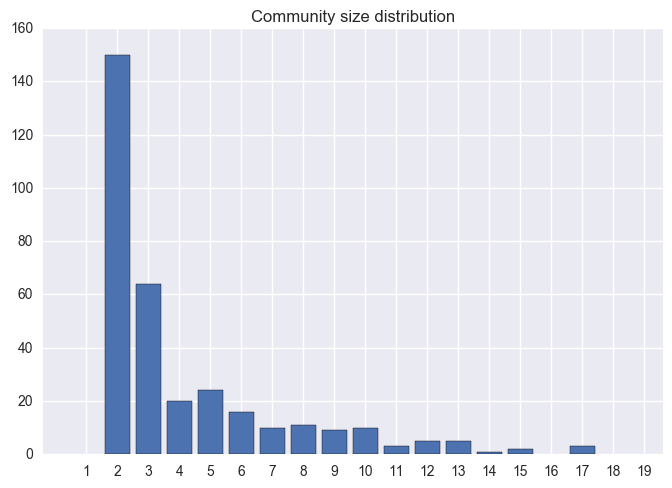

In [54]:
number_of_participants_counter = defaultdict(int)
for users in communities.values():
    number_of_participants_counter[len(users)] += 1
    
plt.figure()
plt.title("Community size distribution")
plt.bar(number_of_participants_counter.keys(), number_of_participants_counter.values())
plt.xlim(0, 20)
plt.xticks(np.array(range(1, 20))+0.4, range(1, 20))
plt.show()

**Conclusion:** *Most communities are dyads.*

#### **Community participation**

**What do the participation profiles look like?**

In [101]:
community_participation = defaultdict(lambda: defaultdict(list))
for c, members in communities.items():
    for l, coms in layer_communities.items():
        if c not in coms: continue
        for participant in coms[c]:
            community_participation[c][participant].append(1)
        for non_participant in (set(members) - set(coms[c])):
            community_participation[c][non_participant].append(0)
            
    community_participation[c] = dict(
        (m, np.mean(l))
        for m, l in community_participation[c].items()
    )

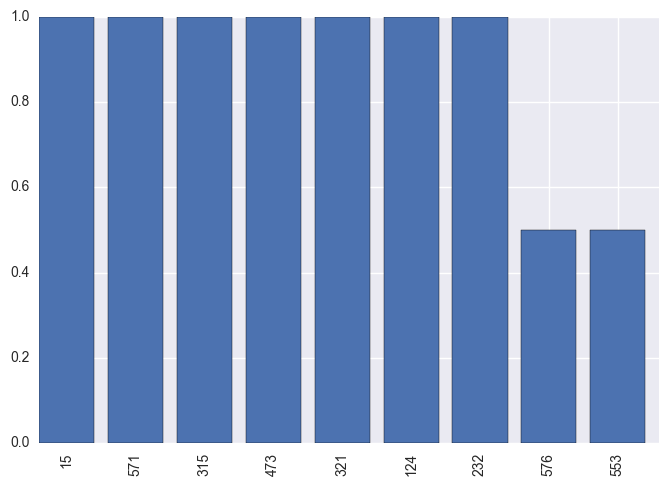

In [104]:
x, y = zip(*sorted(community_participation[330].items(), key=lambda v: v[1], reverse=True))
plt.bar(range(len(x)), y)
plt.xticks(np.arange(0, len(x))+0.4, x, rotation=90)
plt.show()

**How many communities are each person associated with?
How many cores are each person a part of?**

In [247]:
def above_max_dist(v, series):
    def _max_dist(series):
        return max(
            [
                (vi - vj, vj)
                for vi, vj in zip(sorted(series)[1:], sorted(series)[:-1])
            ],
            key=lambda x: x[0]
        )[1]
    return v > _max_dist(series)
    

In [248]:
user_communities = dict((u, 0) for u in set([u for members in communities.values() for u in members]))
user_cores = dict((u, 0) for u in set([u for members in communities.values() for u in members]))
for c, users in communities.items():
    for user in users:
        user_communities[user] += 1
        
        # One community contains only a single member
        if len(community_participation[c]) < 2: continue
            
        if above_max_dist(community_participation[c][user], community_participation[c].values()): 
            user_cores[user] += 1

number_of_cores_counter = defaultdict(int)
for number_of_cores in user_cores.values():
    number_of_cores_counter[number_of_cores] += 1
number_of_communities_counter = defaultdict(int)
for number_of_communities in user_communities.values():
    number_of_communities_counter[number_of_communities] += 1

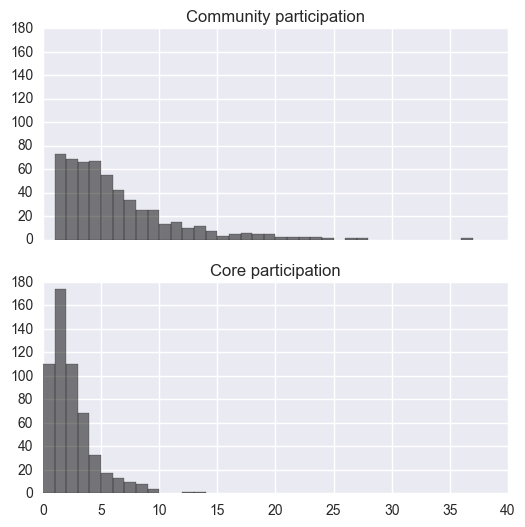

In [249]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6, 6), sharex=True, sharey=True)

ax1.bar(number_of_communities_counter.keys(), number_of_communities_counter.values(), 1, alpha=0.5, color="k")
ax2.bar(number_of_cores_counter.keys(), number_of_cores_counter.values(), 1, alpha=0.5, color="k")

ax1.set_title("Community participation")
ax2.set_title("Core participation")

plt.xlim([0, 40])
plt.show()

**Conclusion:** *Most people are part of multiple communities, but only core to very few. Many are core to zero communities.*

#### **How connected are people to other's not in the immediate community?**

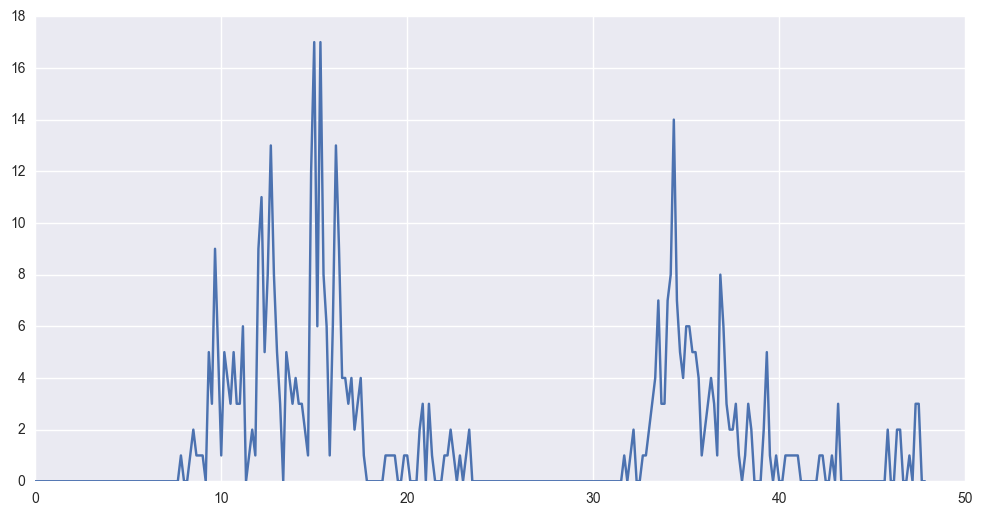

In [250]:
x, y = [], []
for l in range(len(layers)):
    edges_true = set([
        tuple(sorted((e['source'], e['target'])))
        for e in ds['layer_networks']['data'][l]['links']
    ])
    edges_comm = set([
        tuple(sorted((int(mi), int(mj))))
        for c in ds['layer_networks']['data'][l]['groups'].values()
        for i, mi in enumerate(c)
        for j, mj in enumerate(c)
        if i < j
    ])
    x.append(l)
    y.append(len(edges_true-edges_comm))

plt.figure(figsize=(12, 6))
plt.plot(np.array(x)/6.0, y)
#plt.xlim([0, 24])
#plt.xticks(range(25))
plt.show()

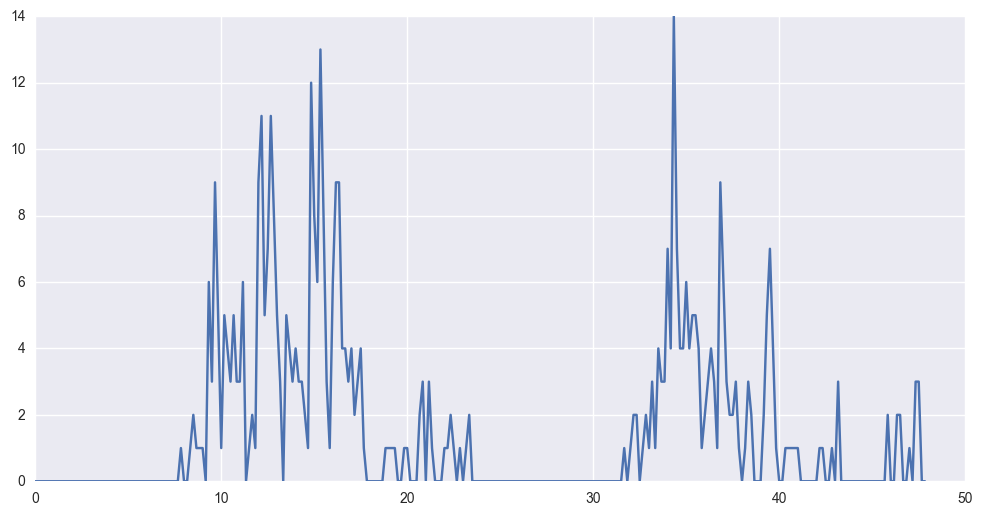

In [257]:
x, y = [], []
for l in range(len(layers)):
    edges_true = set([
        tuple(sorted((e['source'], e['target'])))
        for e in ds['layer_networks']['data'][l]['links']
    ])
    edges_comm = set([
        tuple(sorted((int(mi), int(mj))))
        for c in ds['layer_networks']['data'][l]['groups'].values()
        for i, mi in enumerate(c)
        for j, mj in enumerate(c)
        if i < j
    ])
    x.append(l)
    y.append(len(edges_true-edges_comm))

plt.figure(figsize=(12, 6))
plt.plot(np.array(x)/(12.0/fof), y)
#plt.xlim([0, 24])
#plt.xticks(range(25))
plt.show()

#### **What is the distribution of memorylink weights?**

In [296]:
# Parse pajek file output by Infomap
with open('output/tmpnet.net', 'r') as fp:
    links = [l.split() for l in re.findall(r'\d+ \d+ \d+ \d+ .+', fp.read())]

In [299]:
# Get memory link weights
interlayer_link_weights = []
for l in links:
    if l[0] != l[2]:
        interlayer_link_weights.append(eval(l[-1]))

In [ ]:
# Sort memory links into links within and between communities
p_ticks = 100
progress = map(int, np.linspace(0, len(links), p_ticks))

within_weight, between_weight = [], []
for p, l in enumerate(links):
    if p in progress:
        #print "%d%%" % (progress.index(p) * 100 / p_ticks),
    layer_i, layer_j = int(l[0]), int(l[2])
    if layer_i != layer_j:
        node_i, node_j = l[1], l[3]
        for k, v in layer_communities[layer_i].items():
            if node_i in v:
                comm_i = k
                break
        for k, v in layer_communities[layer_j].items():
            if node_j in v:
                comm_j = k
                break
        if comm_i == comm_j:
            within_weight.append(float(l[4]))
        else:
            between_weight.append(float(l[4]))

In [ ]:
# Plotting functions
def plt_log_hist(v, bins=10):
    """Make logplot of histogram."""
    plt.hist(v, bins=np.logspace(np.log10(min(v)), np.log10(max(v)), bins))
    plt.xscale("log")
def plt_cumulative_hist(v, bins=10):
    values, base = np.histogram(v, bins=bins)
    cumulative = np.cumsum(values)
    plt.plot(base[:-1], cumulative)

**Distribution of ALL memory link weights**

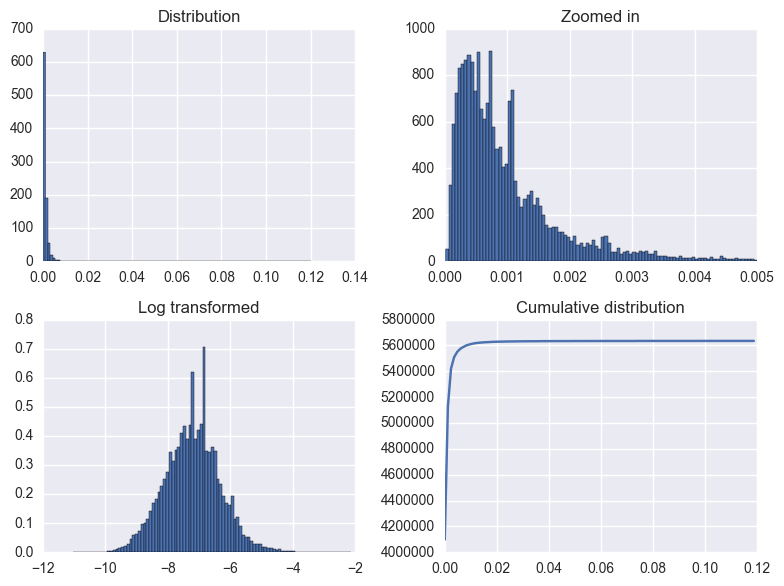

In [443]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1); plt.title("Distribution")
plt.hist(interlayer_link_weights, bins=110, normed=True)
plt.subplot(2, 2, 2); plt.title("Zoomed in")
plt.hist([w for w in interlayer_link_weights if w < 0.005], bins=100, normed=True)
plt.subplot(2, 2, 3); plt.title("Log transformed")
plt.hist(np.log(interlayer_link_weights), bins=100, normed=True)
plt.subplot(2, 2, 4); plt.title("Cumulative distribution")
plt_cumulative_hist(interlayer_link_weights, bins=100)

plt.tight_layout()
plt.show()

**Distribution of memory link weights WITHIN communities**

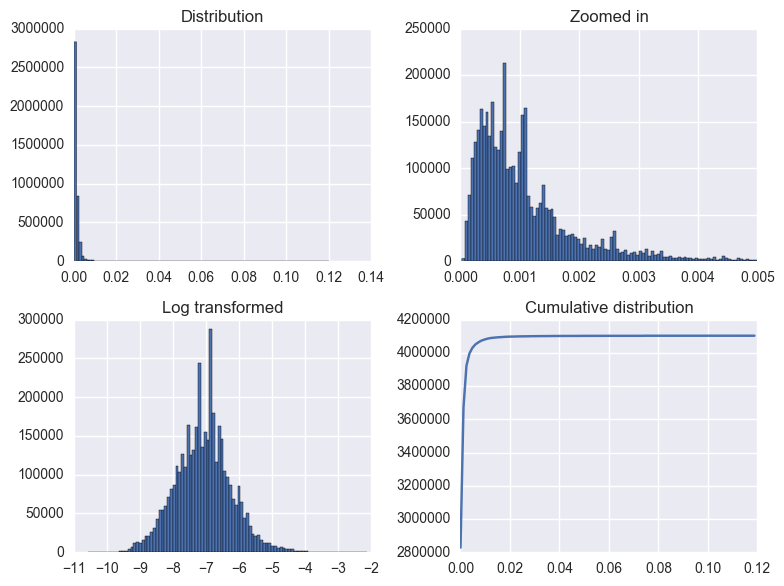

In [428]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1); plt.title("Distribution")
plt.hist(within_weight, bins=100)
plt.subplot(2, 2, 2); plt.title("Zoomed in")
plt.hist([w for w in within_weight if w < 0.005], bins=100)
plt.subplot(2, 2, 3); plt.title("Log transformed")
plt.hist(np.log(within_weight), bins=100)
plt.subplot(2, 2, 4); plt.title("Cumulative distribution")
plt_cumulative_hist(within_weight, bins=100)

plt.tight_layout()
plt.show()

**Distribution of memory link weights BETWEEN communities**

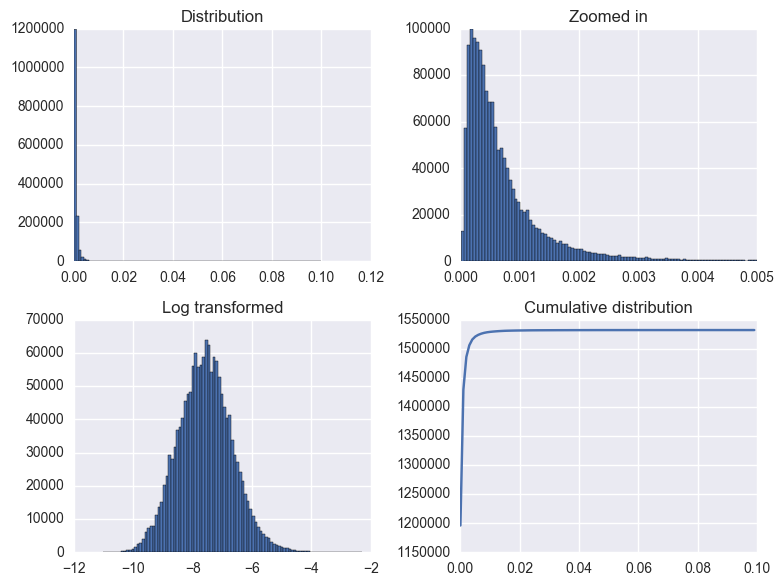

In [429]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1); plt.title("Distribution")
plt.hist(between_weight, bins=100)
plt.subplot(2, 2, 2); plt.title("Zoomed in")
plt.hist([w for w in between_weight if w < 0.005], bins=100)
plt.subplot(2, 2, 3); plt.title("Log transformed")
plt.hist(np.log(between_weight), bins=100)
plt.subplot(2, 2, 4); plt.title("Cumulative distribution")
plt_cumulative_hist(between_weight, bins=100)

plt.tight_layout()
plt.show()

**What fraction of links carry what fraction of weight? How many links are removed for varying thresholds?**

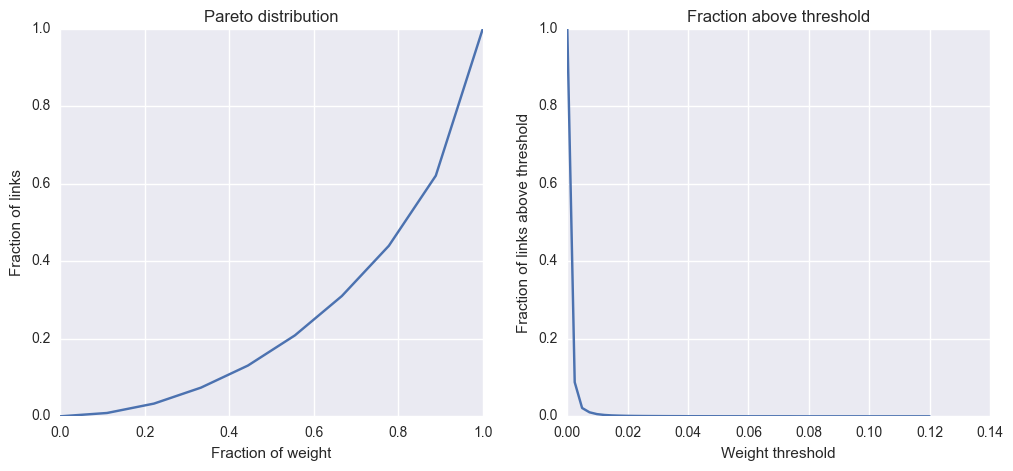

In [394]:
def pareto_distribution(v, p=0.8):
    """Gets the fraction of entries in v which accounts for p times sum.
    v has to be sorted in descending order."""
    thr = np.sum(v)*p
    cumsum = 0
    for i, _v in enumerate(v, 1):
        cumsum += _v
        if cumsum >= thr:
            return i * 1.0 / len(v)
        
def fraction_above(v, thr):
    """Gets the fraction of entries in v which accounts for p times sum.
    v has to be sorted in descending order."""
    return len([w for w in v if w > thr]) * 1.0 / len(v)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.title("Pareto distribution")
x = np.linspace(0, 1, 10)
y = [pareto_distribution(interlayer_link_weights, p) for p in x]
plt.plot(x, y)
plt.xlabel("Fraction of weight"); plt.ylabel("Fraction of links")
plt.subplot(1, 2, 2); plt.title("Fraction above threshold")
x = np.linspace(0, np.max(interlayer_link_weights), 50)
y = [fraction_above(interlayer_link_weights, t) for t in x]
plt.plot(x, y)
plt.xlabel("Weight threshold"); plt.ylabel("Fraction of links above threshold")
plt.show()

**Conclusion:** *40% of the weight is carried by only 10% of the links*

In [427]:
print "len", len(within_weight) * 1.0 / len(between_weight)
print "sum", np.sum(within_weight) / np.sum(between_weight)
print "mean", np.mean(within_weight) / np.mean(between_weight)
print "median", np.median(within_weight) / np.median(between_weight)

len 2.67816314035
sum 4.2491162338
mean 1.58657856565
median 1.68318882603


**Conclusion:** *There are 2.7 times the links and 4.2 the weight inside communities compared to between them. The mean value of links inside is 1.6 times that of the mean value between.*

**Problem:** The heavy tail on the distribution of memory link weights may be an attribute of the way we normalize outgoing links on state nodes. Instead I now turn to investigating the distribution of similarity links between state nodes.

#### **Distribution of JS similarities**

In [60]:
def jsdiv(P, Q):
    """Compute the Jensen-Shannon divergence between two probability distributions.
    
    Input
    -----
    P, Q : array-like
        Probability distributions of equal length that sum to 1
    """
    
    def _kldiv(A, B):
        return np.sum([v for v in A * np.log2(A/B) if not np.isnan(v)])

    P = np.array(P)
    Q = np.array(Q)
    
    M = 0.5 * (P + Q)
    
    return 0.5 * (_kldiv(P, M) + _kldiv(Q, M))

def jacsim(P, Q):
    """Compute the Jaccard divergence between two probability distributions.
    
    Input
    -----
    P, Q : array-like
        Probability distributions of equal length that sum to 1
    """
    
    P = set([v for v, p in enumerate(P) if p == 1])
    Q = set([v for v, q in enumerate(Q) if q == 1])
    
    return len(P & Q) * 1.0 / len(P | Q)

def randomize_by_edge_swaps(G, num_iterations):
    """Randomizes the graph by swapping edges in such a way that
    preserves the degree distribution of the original graph.

    Source: https://gist.github.com/gotgenes/2770023
    """
    newgraph = G.copy()
    edge_list = newgraph.edges()
    num_edges = len(edge_list)
    total_iterations = num_edges * num_iterations

    for i in xrange(total_iterations):
        rand_index1 = int(round(random.random() * (num_edges - 1)))
        rand_index2 = int(round(random.random() * (num_edges - 1)))
        original_edge1 = edge_list[rand_index1]
        original_edge2 = edge_list[rand_index2]
        head1, tail1 = original_edge1
        head2, tail2 = original_edge2

        # Flip a coin to see if we should swap head1 and tail1 for
        # the connections
        if random.random() >= 0.5:
            head1, tail1 = tail1, head1

        if head1 == tail2 or head2 == tail1:
            continue

        if newgraph.has_edge(head1, tail2) or newgraph.has_edge(
                head2, tail1):
            continue

        # Suceeded checks, perform the swap
        original_edge1_data = newgraph[head1][tail1]
        original_edge2_data = newgraph[head2][tail2]

        newgraph.remove_edges_from((original_edge1, original_edge2))

        new_edge1 = (head1, tail2, original_edge1_data)
        new_edge2 = (head2, tail1, original_edge2_data)
        newgraph.add_edges_from((new_edge1, new_edge2))

        # Now update the entries at the indices randomly selected
        edge_list[rand_index1] = (head1, tail2)
        edge_list[rand_index2] = (head2, tail1)

    assert len(newgraph.edges()) == num_edges
    return newgraph

In [69]:
P = np.array([1, 1, 0, 0]); _P = P * 1.0 / sum(P)
Q = np.array([1, 1, 1, 1]); _Q = Q * 1.0 / sum(Q)
print 1 - jsdiv(_Q, _P)
print jacdiv(Q, P)

0.688721875541
0.5


/Library/Python/2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log2
/Library/Python/2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in multiply


In [57]:
set(P) & set(Q)

{0, 1}

In [1272]:
# ------------------------------------- #
# Create a networkx graph of each layer # 
# ------------------------------------- #

intralayer_links = [l.split() for l in re.findall(r'\d+ \d+ \d+ \d.+', multiplex_file_string)]

layer_graphs = defaultdict(nx.classes.graph.Graph)
node_layers = defaultdict(set)

for l in intralayer_links:
    layer_graphs[int(l[0])].add_edge(int(l[1]), int(l[2]), w=float(l[3]))
    node_layers[int(l[1])].add(int(l[0]))
    node_layers[int(l[2])].add(int(l[0]))
    
layers = layer_graphs.keys()

In [ ]:
# ---------------------------------------- #
# Compute distribution of similarity links # 
# ---------------------------------------- #

similarity_weights = []
count_memory_links = []

for node, layers in node_layers.items():
    print node,
    for i, li in enumerate(layers):
        for j, lj in enumerate(layers):
            
            # if i >= j: continue  # use this to exclude self-similarities
            if i > j: continue
                
            Pi = layer_graphs[li].neighbors(node)
            Pj = layer_graphs[lj].neighbors(node)
            
            if len(set(Pi) & set(Pj)) == 0:
                similarity_weights.append(0)
                count_memory_links.append(len(Pi) + len(Pj))
                continue
            
            count_to = max(Pi + Pj) + 1
            
            _Pi = [0]*count_to
            _Pj = [0]*count_to
            
            for pin in Pi:
                _Pi[pin] = 1.0 / len(Pi)
            for pjn in Pj:
                _Pj[pjn] = 1.0 / len(Pj)
            
            div = jsdiv(_Pj, _Pi)
                
            similarity_weights.append(1-div)
            count_memory_links.append(len(Pi) + len(Pj))

In [ ]:
#similarity_weights_null_all_iter = []

for _iter in range(1000):
    
    if _iter % 10 == 0:
        print _iter
    
    similarity_weights_null = []

    layer_graphs_null = [randomize_by_edge_swaps(layer_graphs[li], 10) for li in layer_graphs.keys()]
    for node, layers in node_layers.items():
        for i, li in enumerate(layers):
            for j, lj in enumerate(layers):

                # if i >= j: continue  # use this to exclude self-similarities
                if i > j: continue

                Pi = layer_graphs_null[li].neighbors(node)
                Pj = layer_graphs_null[lj].neighbors(node)

                if len(set(Pi) & set(Pj)) == 0:
                    similarity_weights_null.append(0)
                    continue

                count_to = max(Pi + Pj) + 1

                _Pi = [0]*count_to
                _Pj = [0]*count_to

                for pin in Pi:
                    _Pi[pin] = 1.0 / len(Pi)
                for pjn in Pj:
                    _Pj[pjn] = 1.0 / len(Pj)

                div = jsdiv(_Pj, _Pi)

                similarity_weights_null.append(1-div)
    
    similarity_weights_null_all_iter.append(similarity_weights_null)
        

In [719]:
# Create zero-free distributions
similarity_weights_nonzero = [v for v in similarity_weights if v != 0]
count_memory_links_nonzero = [e2 for e1, e2 in zip(similarity_weights, count_memory_links) if e1 != 0]
similarity_weights_null_nonzero = [v for v in similarity_weights_null if v != 0]

In [836]:
# Compute p-values for each distinct similiarty weight
similarity_p_values = defaultdict(float)

similarity_weights_null_counter_all_iter = [Counter(similarity_weights_null) for similarity_weights_null in similarity_weights_null_all_iter]
for w, c in Counter(similarity_weights_nonzero).items():
    p_arr = []
    for null_counter in similarity_weights_null_counter_all_iter:
        if w in null_counter:
            p_arr.append(1 if float(null_counter[w]) > c else 0)
        
    similarity_p_values[w] = np.mean(p_arr)

/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


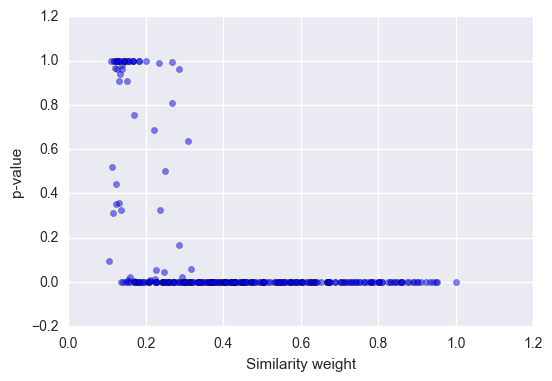

In [843]:
# Plot distribution of p-values
x, y = zip(*[(k, v) for k, v in sorted(similarity_p_values.items(), key=lambda kv: kv[0]) if True]); y = np.nan_to_num(y)

plt.scatter(x, y, alpha=.5)
plt.ylabel("p-value")
plt.xlabel("Similarity weight")
plt.show()

**Conclusion:** *Similarity links with weight greater than ~0.32 are statistically significant.*

In [ ]:
# Create flat distribution of all random similiarty weights
weights_null_all_dist = []
for similarity_weights_null in similarity_weights_null_all_iter:
    for v in similarity_weights_null:
        if v != 0:
            weights_null_all_dist.append(v)

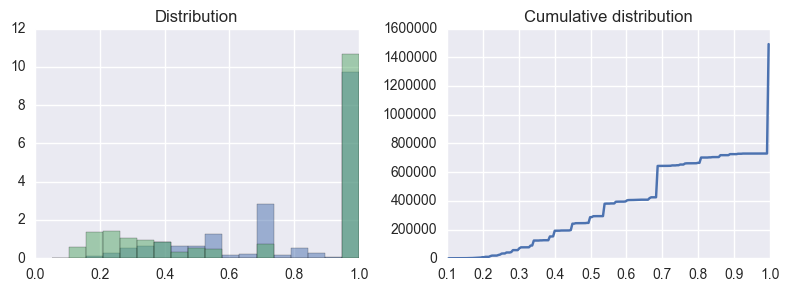

In [862]:
# Plot distribution of real and random similarity weights
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1); plt.title("Distribution")
plt.hist(similarity_weights_nonzero, bins=np.linspace(0, 1, 20), normed=True, alpha=0.5)
plt.hist(weights_null_all_dist, bins=np.linspace(0, 1, 20), normed=True, alpha=0.5)
plt.subplot(1, 2, 2); plt.title("Cumulative distribution")
plt_cumulative_hist(similarity_weights_nonzero, bins=200)

plt.tight_layout()
plt.show()

**Conclusion:** *The similarity weight peaks around 0.2-0.5 in the mean field.*

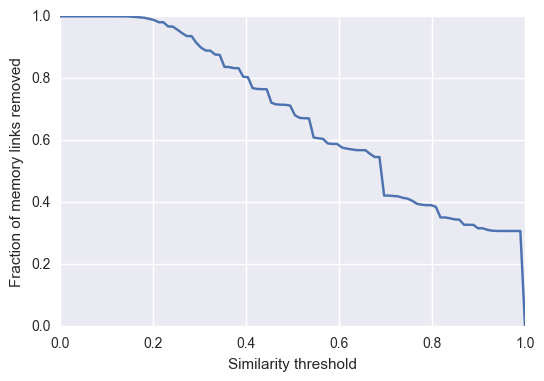

In [1002]:
# Threshold link counting
def thr_memorylink_fraction(thr):
    return sum([
        c for (v, c) in 
        filter(
            lambda (v, c): v > thr,
            zip(similarity_weights_nonzero, count_memory_links_nonzero)
        )
    ]) * 1.0 / sum(count_memory_links_nonzero)

x = np.linspace(0, 1, 100)
y = [thr_memorylink_fraction(thr) for thr in x]
plt.plot(x, y)
plt.xlabel("Similarity threshold")
plt.ylabel("Fraction of memory links conserved")
plt.show()

**Conclusion:** *A similarity threshold at 0.6 removes ~ 40% of the memory links.*

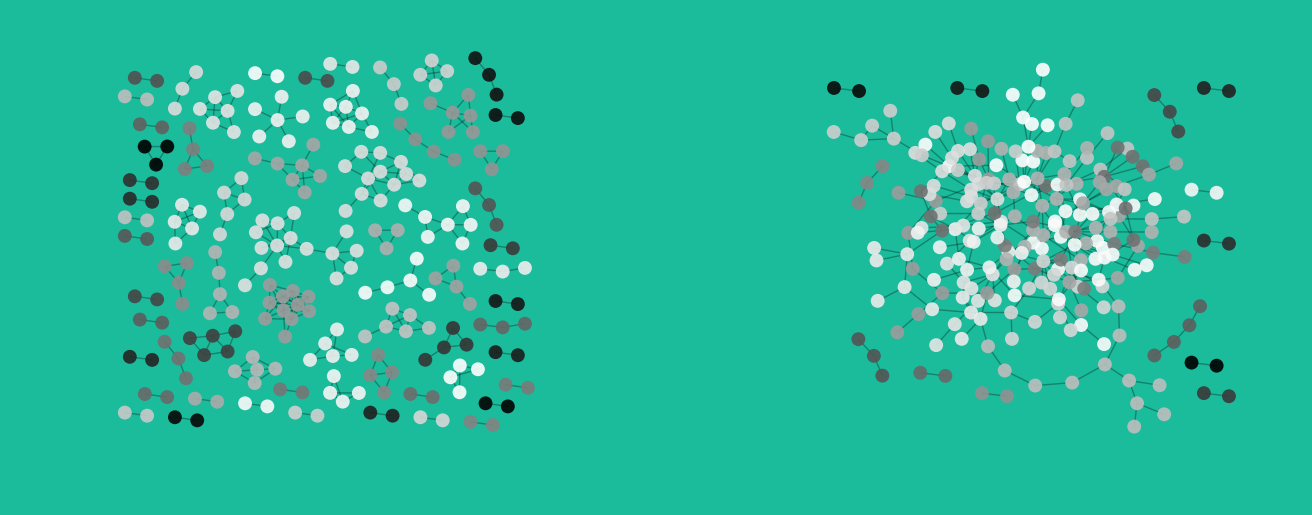

In [928]:
def draw(G, community_detection=False):
    """Draw graph G in my standard style."""
    
    if community_detection:
        partition = community.best_partition(G)
        partition = [partition[n] for n in G.nodes()]
    else:
        partition = "grey"
    
    pos = nx.nx_pydot.graphviz_layout(G, prog='neato')
    nx.draw_networkx_edges(G, pos=pos, width=1, alpha=.3)
    nx.draw_networkx_nodes(G, pos=pos, node_size=100, alpha=0.9, linewidths=0, node_color=partition)
    #nx.draw_networkx_labels(G, pos=pos, font_color="red")
    plt.axis("off")

plt.figure(figsize=(16, 6), facecolor="#1abc9c")

plt.subplot(1, 2, 1)
draw(layer_graphs[65], community_detection=True)

plt.subplot(1, 2, 2)
draw(randomize_by_edge_swaps(layer_graphs[65], 10000), community_detection=True)

plt.show()

**Conclusion:** *Edge swapping makes the clustering vanish.*

#### **Toying with statistical model for computing JSD null model**

In [1473]:
def JSD(i, g, h):
    
    Jp = sorted(set([
        n
        for l in [graph.nodes() for _, graph in layer_graphs.items()]
        for n in l
    ]))
    
    def KLD(A, B):
        return - np.sum([v for v in A * np.log2((A + B) * 0.5 / A) if not np.isnan(v)])
    
    try:
        Pg = [1 if j in layer_graphs[g].neighbors(i) else 0 for j in Jp]
        Ph = [1 if j in layer_graphs[h].neighbors(i) else 0 for j in Jp]
    except nx.NetworkXError:
        return 1.0
    
    Pg = np.array(Pg) * 1.0 / sum(Pg)
    Ph = np.array(Ph) * 1.0 / sum(Ph)
    
    return 0.5 * (KLD(Pg, Ph) + KLD(Ph, Pg))


def JSD_null(i, g, h):
    
    def k(node_index, layer_index):
        try:
            return layer_graphs[layer_index].degree()[node_index]
        except KeyError as e:
            #print "node %d doesn't exist in layer %d" % (node_index, layer_index)
            return 0
    def M(layer_index):
        return len(layer_graphs[layer_index].edges())
    
    def P(i, j, layer_index):
        return k(i, layer_index) * k(j, layer_index) * 1.0 / (2 * M(layer_index) - 1)

    def KLD(Pl, Pm):
        return np.sum([pl * np.log2(pl * 1.0 / pm) for pl, pm in zip(Pl, Pm) if 0 not in [pl, pm]])
    
    # Physical node ids 
    Jp = sorted(set([
        n
        for l in [graph.nodes() for _, graph in layer_graphs.items()]
        for n in l
    ]))
    
    # Probability distributions
    Pig = np.array([P(i, j, g) for j in Jp])
    Pih = np.array([P(i, j, h) for j in Jp])
    if 0 in [sum(Pg), sum(Ph)]: return 1.0
    Pig = Pig / sum(Pg)
    Pih = Pih / sum(Ph)
    
    Pim = np.array([(Pig[node_index] + Pih[node_index]) / 2.0 for node_index, j in enumerate(Jp)])
    
    return 0.5 * (KLD(Pig, Pim) + KLD(Pih, Pim))

$P_{i,j,p} = \dfrac{k_{i,p}k_{j,p}}{2M_p-k_{i,p}}$, $P_{i,j,q} = \dfrac{k_{i,q}k_{j,q}}{2M_q-k_{i,q}}$

$P_{i,j,m} = (P_{i,j,p} + P_{i,j,q})/2$

$\mathrm{JSD}_i(P, Q) = \dfrac{1}{2}\left(\mathrm{KLD}(P, M) + \mathrm{KLD}(Q, M)\right)$

$\mathrm{JSD}_i(P, Q) = \dfrac{1}{2}\left(\sum_j{P_j \log2{\dfrac{P_j}{M_j}}} + \sum_j{Q_j \log2{\dfrac{Q_j}{M_j}}}\right)$

$\mathrm{JSD}_i(P, Q) = \dfrac{1}{2}\left(\sum_j{P_j \log2{\dfrac{P_j}{(P_j + Q_j)/2}}} + \sum_j{Q_j \log2{\dfrac{Q_j}{(P_j + Q_j)/2}}}\right)$

$\mathrm{JSD}_i(P, Q) = \dfrac{1}{2}\left(\sum_j{P_j \log2{\dfrac{2}{(1 + Q_j/P_j)}}} + \sum_j{Q_j \log2{\dfrac{2}{(1+P_j/Q_j)}}}\right)$

$\mathrm{JSD}_i(P, Q) = \dfrac{1}{2}\left(\sum_j{\dfrac{k_{j,p}}{2M_p-k_{i,p}} \log2{\dfrac{2}{(1 + \dfrac{k_{j,q}}{2M_q-k_{i,q}}/\dfrac{k_{j,p}}{2M_p-k_{i,p}})}}} + \sum_j{\dfrac{k_{j,q}}{2M_q-k_{i,q}} \log2{\dfrac{2}{(1+\dfrac{k_{j,p}}{2M_p-k_{i,p}}/\dfrac{k_{j,q}}{2M_q-k_{i,q}})}}}\right)$

$\mathrm{JSD}_i(P, Q) = \dfrac{1}{2}\left(\sum_j{\dfrac{k_{j,p}}{2M_p-k_{i,p}} \log2{\dfrac{2}{(1 + \dfrac{k_{j,q}}{k_{j,p}}\dfrac{2M_q-k_{i,q}}{2M_p-k_{i,p}})}}} + \sum_j{\dfrac{k_{j,q}}{2M_q-k_{i,q}} \log2{\dfrac{2}{(1+\dfrac{k_{j,p}}{k_{j,q}}\dfrac{2M_p-k_{i,p}}{2M_q-k_{i,q}})}}}\right)$

$\mathrm{JSD}_i(P, Q) = -\dfrac{1}{2}\left(\sum_j{\dfrac{k_{j,p}}{2M_p-k_{i,p}} \log2{\dfrac{1}{2}\left(1 + \dfrac{k_{j,q}}{k_{j,p}}\dfrac{2M_q-k_{i,q}}{2M_p-k_{i,p}}\right)} } + \sum_j{\dfrac{k_{j,q}}{2M_q-k_{i,q}} \log2{\dfrac{1}{2}\left(1+\dfrac{k_{j,p}}{k_{j,q}}\dfrac{2M_p-k_{i,p}}{2M_q-k_{i,q}}\right)}}\right)$

For the configuration model with degree distribution $\mathrm{\textbf{k}}$ and number of nodes and edges $N$ and $M$ in layer $l$ of a temporal network, the probability that an edge exists between node $i$ and $j$ is given by the Bernoulli distribution:

$P_{i,j,l} = \dfrac{k_{i,l}k_{j,l}}{2M_l-k_{i,l}}$

The Jensen Shannon divergence of the neighborhood of node $i$ between layers $p$ and $q$ is given by:

$JSD(i, p, q) = \dfrac{1}{2} \left( KLD(i, p, m) + KLD(i, q, m) \right)$,

where $m$ denotes the index of the "mean layer" with edge probabilities $P_{i, j, m} = \frac{1}{2} \left( P_{i, j, p} + P_{i, j, q} \right)$

Normally the Kullback–Leibler divergence compares two propability distributions, where a probability distribution in this case would be a vector where each entry gave the probability that a random walker standing at node $i$ would travel to node $j$. Naively, we could just normalize $\mathrm{\textbf{k}}_{i,l}$ to 1 in both layers and use these vectors as input to the KLD function, but for the configuration model this give very similar probability distributions in both layers. We realize that we get a zero contribution to the KLD when the same link exists in both layers, and a positive contribution (increasing the divergence) for diverging links.

$KLD(i, l, m) = -\sum_j{R_{i, l, m}}$

$
\begin{equation}
    R_{i, l, m} =
    \begin{cases}
        k_{i, p}^{-1} \log2{\frac{1}{2} \left( 1 + \frac{k_{i, m}}{k_{i, q}} \right)}, & \tilde{P_{i, p, j}} = 1, \tilde{P_{i, q, j}} = 1 \\
        -k_{i, p}^{-1}, & \tilde{P_{i, p, j}} = 1, \tilde{P_{i, q, j}} = 0 \\
        0, & \tilde{P_{i, p, j}} = 0, \tilde{P_{i, q, j}} = 1 \\
        0, & \tilde{P_{i, p, j}} = 0, \tilde{P_{i, q, j}} = 0
    \end{cases}
\end{equation}
$

The probabilities of each case is given by:

$Pr(\tilde{P_{i, p, j}} = 1, \tilde{P_{i, q, j}} = 1)) = P_{i, p, j} P_{i, q, j}$

$Pr(\tilde{P_{i, p, j}} = 1, \tilde{P_{i, q, j}} = 0)) = P_{i, p, j} (1-P_{i, q, j})$

$Pr(\tilde{P_{i, p, j}} = 0, \tilde{P_{i, q, j}} = 1)) = (1-P_{i, p, j}) P_{i, q, j}$

$Pr(\tilde{P_{i, p, j}} = 0, \tilde{P_{i, q, j}} = 0)) = (1-P_{i, p, j}) (1-P_{i, q, j})$

The KLD between $P_{i, p}$ and $P_{i, m}$ can be rewritten to only depend on $P_{i, p}$ and $P_{i, q}$:

$KLD(i, p, q) = -\sum_j{Pr(\tilde{P_{i, p, j}} = 1, \tilde{P_{i, q, j}} = 1))k_{i, p}^{-1} \log2{\frac{1}{2} \left( 1 + \dfrac{k_{i, p}}{k_{i, q}} \right)} - Pr(\tilde{P_{i, p, j}} = 1, \tilde{P_{i, q, j}} = 0)) k_{i, p}^{-1}}$

$KLD(i, p, q) = -\sum_j{P_{i, p, j} P_{i, q, j} k_{i, p}^{-1} \log2{\frac{1}{2} \left( 1 + \dfrac{k_{i, p}}{k_{i, q}} \right)} - P_{i, p, j} (1-P_{i, q, j}) k_{i, p}^{-1}}$

$KLD(i, p, q) = -\sum_j{\dfrac{k_{i,p}k_{j,p}}{2M_p-k_{i,p}} \dfrac{k_{i,q}k_{j,q}}{2M_q-k_{i,q}} k_{i, p}^{-1} \log2{\frac{1}{2} \left( 1 + \dfrac{k_{i, p}}{k_{i, q}} \right)} - \dfrac{k_{i,p}k_{j,p}}{2M_p-k_{i,p}} (1-\dfrac{k_{i,q}k_{j,q}}{2M_q-k_{i,q}}) k_{i, p}^{-1}}$

$KLD(i, p, q) = -\sum_j{\dfrac{k_{j,p}}{2M_p-k_{i,p}} \dfrac{k_{i,q}k_{j,q}}{2M_q-k_{i,q}} \log2{\frac{1}{2} \left( 1 + \dfrac{k_{i, p}}{k_{i, q}} \right)} - \dfrac{k_{j,p}}{2M_p-k_{i,p}} (1-\dfrac{k_{i,q}k_{j,q}}{2M_q-k_{i,q}})}$

$KLD(i, p, q) = -\sum_j{\dfrac{k_{j,p}}{2M_p-k_{i,p}} \left( \dfrac{k_{i,q}k_{j,q}}{2M_q-k_{i,q}} \log2{\frac{1}{2} \left( 1 + \dfrac{k_{i, p}}{k_{i, q}} \right)} - (1-\dfrac{k_{i,q}k_{j,q}}{2M_q-k_{i,q}}) \right)}$

**Finally:**

$KLD(i, p, q) = -\sum_j{\dfrac{k_{j,p}}{2M_p-k_{i,p}} \left( \dfrac{k_{i,q}k_{j,q}}{2M_q-k_{i,q}} \left( \log2{\frac{1}{2} \left( 1 + \dfrac{k_{i, p}}{k_{i, q}} \right)} + 1\right) - 1 \right)}$

Similarly:

$KLD(i, q, p) = -\sum_j{\dfrac{k_{j,q}}{2M_q-k_{i,q}} \left( \dfrac{k_{i,p}k_{j,p}}{2M_p-k_{i,p}} \left( \log2{\frac{1}{2} \left( 1 + \dfrac{k_{i, q}}{k_{i, p}} \right)} + 1\right) - 1 \right)}$

Which gives:

$JSD(i, p, q) = -\frac{1}{2} \left(\sum_j{\dfrac{k_{j,p}}{2M_p-k_{i,p}} \left( \dfrac{k_{i,q}k_{j,q}}{2M_q-k_{i,q}} \left( \log2{\frac{1}{2} \left( 1 + \dfrac{k_{i, p}}{k_{i, q}} \right)} + 1\right) - 1 \right)} + \sum_j{\dfrac{k_{j,q}}{2M_q-k_{i,q}} \left( \dfrac{k_{i,p}k_{j,p}}{2M_p-k_{i,p}} \left( \log2{\frac{1}{2} \left( 1 + \dfrac{k_{i, q}}{k_{i, p}} \right)} + 1\right) - 1 \right)} \right)$

In [1549]:
def k(node_index, layer_index):
    try:
        return layer_graphs[layer_index].degree()[node_index]
    except KeyError as e:
        #print "node %d doesn't exist in layer %d" % (node_index, layer_index)
        return 0
def M(layer_index):
    return len(layer_graphs[layer_index].edges())
    
def JSD_null(i, p, q):
    
    physical_nodes = sorted(set([
        n
        for l in [graph.nodes() for _, graph in layer_graphs.items()]
        for n in l
    ]))
        
    if k(i, p) == 0 or k(i, q) == 0:
        return 1
    
    return - 0.5 * (
        sum(
            [
                float(k(j, p)) / (2 * M(p) - k(i, p)) * ( float(k(i, q) * k(j, q)) / (2 * M(q) - k(i, q)) * ( np.log2( 0.5 * ( 1 + float(k(i, p)) / k(i, q) ) ) + 1 ) - 1 )
                for j in physical_nodes if k(j, p) != 0
            ] 
        ) + \
        sum(
            [
                float(k(j, q)) / (2 * M(q) - k(i, q)) * ( float(k(i, p) * k(j, p)) / (2 * M(p) - k(i, p)) * ( np.log2( 0.5 * ( 1 + float(k(i, q)) / k(i, p) ) ) + 1 ) - 1 )
                for j in physical_nodes if k(j, q) != 0
            ]
        )
    )

**Conclusion:** This doesn't work! The mean-field distributions are not representative of the probabilities of traversing edges in the null-graph. Since the degree-configuration changes little from layer to layer, the mean-field similarities will be super high compared to simulated null-graph similarities. Instead I think we need to draw $k_{i,p}$ times from $P_{i,p}$ and use the resulting vector as the mean-field vector and then do the same for $q$, then compute JSD for those two and get a distribution over a handful of numbers computed like that to obtain the probability of various JSDs.

In [1524]:
def k(node_index, layer_index):
    try:
        return layer_graphs[layer_index].degree()[node_index]
    except KeyError as e:
        #print "node %d doesn't exist in layer %d" % (node_index, layer_index)
        return 0
def M(layer_index):
    return len(layer_graphs[layer_index].edges())
    
def JSD_null(i, p, q):
    
    physical_nodes = sorted(set([
        n
        for l in [graph.nodes() for _, graph in layer_graphs.items()]
        for n in l
    ]))
        
    if k(i, p) == 0 or k(i, q) == 0:
        return 0
    
    return - 0.5 * (
        sum(
            [
                (k(i, p) - c) * (k(j, p) - c) / (2.0 * M(p) - 1) * np.log2(0.5 * (1 + k(j, q) / k(j, p) * (2.0 * M(q) - 1) / (2.0 * M(p) - 1)))
                for c, j in enumerate(sorted(physical_nodes, key=lambda *args: random.random())) if k(j, p) != 0
            ] 
        ) + \
        sum(
            [
                (k(i, p) - c) * (k(j, p) - c) / (2.0 * M(q) - 1) * np.log2(0.5 * (1 + k(j, p) / k(j, q) * (2.0 * M(p) - 1) / (2.0 * M(q) - 1)))
                for c, j in enumerate(sorted(physical_nodes, key=lambda *args: random.random())) if k(j, q) != 0
            ]
        )
    )

In [1513]:
def JSD_null_simulated(i, p, q, n_iter=10):
    
    physical_nodes = sorted(set([
        n
        for l in [graph.nodes() for _, graph in layer_graphs.items()]
        for n in l
    ]))
    
    def KLD(Pl, Pm):
#        return np.sum([v for v in Pl * np.log2(Pl / Pm) if not np.isnan(v)])
        return np.sum([pl * np.log2(pl / pm) for pl, pm in zip(Pl, Pm) if 0 not in [pl, pm]])
    
    JSD_iter = []
    for _ in range(n_iter):
        graph_p = randomize_by_edge_swaps(layer_graphs[p], 100)
        graph_q = randomize_by_edge_swaps(layer_graphs[q], 100)
        
        try:
            Pp = [1 if j in graph_p.neighbors(i) else 0 for j in physical_nodes]
            Pq = [1 if j in graph_q.neighbors(i) else 0 for j in physical_nodes]
        except nx.NetworkXError:
            print "Node missing from layer"
            return

        Pp = np.array(Pp) * 1.0 / sum(Pp)
        Pq = np.array(Pq) * 1.0 / sum(Pq)
        Pm = 0.5 * (Pp + Pq)

        JSD_iter.append(0.5 * (KLD(Pp, Pm) + KLD(Pq, Pm)))
        
    return [np.mean(JSD_iter), np.std(JSD_iter), np.min(JSD_iter), np.max(JSD_iter)]

In [1461]:
def JSD(i, g, h):
    
    Jp = sorted(set([
        n
        for l in [graph.nodes() for _, graph in layer_graphs.items()]
        for n in l
    ]))
    
    def KLD(A, B):
        return - np.sum([v for v in A * np.log2((A + B) * 0.5 / A) if not np.isnan(v)])
    
    try:
        Pg = [1 if j in layer_graphs[g].neighbors(i) else 0 for j in Jp]
        Ph = [1 if j in layer_graphs[h].neighbors(i) else 0 for j in Jp]
    except nx.NetworkXError:
        return 1.0
    
    Pg = np.array(Pg) * 1.0 / sum(Pg)
    Ph = np.array(Ph) * 1.0 / sum(Ph)
    
    
    return 0.5 * (KLD(Pg, Ph) + KLD(Ph, Pg))


def JSD_null(i, g, h):
    
    def k(node_index, layer_index):
        try:
            return layer_graphs[layer_index].degree()[node_index]
        except KeyError as e:
            #print "node %d doesn't exist in layer %d" % (node_index, layer_index)
            return 0
    def M(layer_index):
        return len(layer_graphs[layer_index].edges())
    
    def P(i, j, layer_index):
        return k(i, layer_index) * k(j, layer_index) * 1.0 / (2 * M(layer_index) - 1)

    def KLD(Pl, Pm):
        return np.sum([pl * np.log2(pl * 1.0 / pm) for pl, pm in zip(Pl, Pm) if 0 not in [pl, pm]])
    
    # Physical node ids 
    Jp = sorted(set([
        n
        for l in [graph.nodes() for _, graph in layer_graphs.items()]
        for n in l
    ]))
    
    # Probability distributions
    Pig = np.array([P(i, j, g) for j in Jp])
    Pih = np.array([P(i, j, h) for j in Jp])
    if 0 in [sum(Pg), sum(Ph)]: return 1.0
    Pig = Pig / sum(Pg)
    Pih = Pih / sum(Ph)
    
    Pim = np.array([(Pig[node_index] + Pih[node_index]) / 2.0 for node_index, j in enumerate(Jp)])
    
    return 0.5 * (KLD(Pig, Pim) + KLD(Pih, Pim))

In [1526]:
i, g, h = 0, 65, 66

#print 1-JSD_null_simulated(i, g, h, 10)[0]
print 1-JSD_null(i, g, h)
print 1-JSD(i, g, h)

-8545.35973428
1.0


/Library/Python/2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in divide


In [1370]:
x_null, y_null = [], []
for l in layers:
    x_null.append(l)
    y_null.append(1-JSD_null(0, 65, l))

In [1371]:
x, y = [], []
for l in layers:
    x.append(l)
    y.append(1-JSD(0, 65, l))

/Library/Python/2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in divide
/Library/Python/2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in divide
/Library/Python/2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in multiply


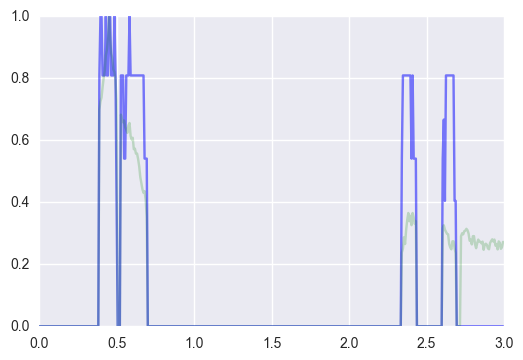

In [1372]:
plt.plot(np.array(x)/144.0, y, c="blue", alpha=0.5)
plt.plot(np.array(x_null)/144.0, y_null, c="green", alpha=0.2)
plt.show()

#### **Visualizing community detection**

In [29]:
def generate_clustered_temporal_network(Nn, Nc, Nnc, Nl, max_dur=None, activation_thr=0.1, debug=False):
    """Generate synthetic clustered temporal network
    
    Input
    -----
    Nn : number of nodes (int)
    Nc : number of communities (int)
    Nnc : number of nodes per community (int)
    Nl : number of layers (int)
    max_dur : maximal duration of each community (int)
    activation_thr : average proportion of active nodes in layers (float)
    
    Output
    ------
    layer_edgelist : list of edge-lists (list)
    """
    
    # Parameter setting
    if max_dur is None:
        max_dur = Nl/20 if Nl/20 > 0 else 1
    
    if activation_thr is None:
        activation_thr = Nnc
        
    if type(Nnc) is not list:
        Nnc = [Nnc]
    
    nodes = range(Nn)
    commu = range(Nc)

    # Construct communities
    commu_nodes = defaultdict(list)
    for c in range(Nc):
        start_from_n = choice(range(Nn))
        for n in range(start_from_n, start_from_n + choice(Nnc)):
            commu_nodes[c].append(n % Nn)

    # Main data structure
    layer_commu = defaultdict(lambda: defaultdict(list))

    # Conditional break parameter
    activation = 0

    while activation < activation_thr:

        if debug:
            raw_input()
            
        # Pick a community
        picked_community = choice(commu_nodes.keys())

        if debug:
            print "Picked community:", picked_community
            print "Member nodes:", commu_nodes[picked_community]
            
        # Pick a duration and a place in time
        duration = choice(range(max_dur))
        layer_start = choice(range(Nl))
        layer_end = layer_start + duration
        layer_end = layer_end if layer_end <= Nl else Nl  # Set ceil of Nl

        if debug:
            print "Duration:", duration, "(", layer_start, "-", layer_end, ")"

        # Check for overlapping nodes
        active_nodes = set()
        for l in range(layer_start, layer_end):
            if l in layer_commu:
                active_nodes.update(layer_commu[l]['nodes'])

        # Restart if any nodes in the picked community are already active
        if len(active_nodes & set(commu_nodes[picked_community])) != 0:
            if debug:
                print "--| nodes already active. RESTART\n"
            continue

        # Add edges to layer_commu datastructure
        for l in range(layer_start, layer_end):
            if len(commu_nodes[picked_community]) < 2:
                continue
            layer_commu[l]['commu'].append(commu_nodes[picked_community])
            layer_commu[l]['nodes'].extend(commu_nodes[picked_community])
        
        # Number of nodes added divided by total capacity
        activation += duration * len(commu_nodes[picked_community]) * 1.0 / (Nl * Nn)

        if debug:
            print "--> community successfully added.",
            print "progress:", activation / activation_thr * 100, "%"
    
    
    # Convert layer_commu to list of edgelists
    def _generate_connected_graph(nodes):
        edges = set()
        for i1, n1 in enumerate(nodes):
            for i2, n2 in enumerate(nodes):
                if i2 > i1:
                    edges.add((n1, n2))
        return edges
    
#     layer_edgelist = [[] for _ in range(Nl)]
#     A = np.zeros((Nn, Nn, Nl))
#     for l, commu_nodes in layer_commu.items():
#         for commu in commu_nodes['commu']:
#             for edge in _generate_connected_graph(commu):
#                 A[edge[0], edge[1], l] = 1
#             layer_edgelist[l].extend(_generate_connected_graph(commu))
            
    A = defaultdict(int)
    for l, commu_nodes in layer_commu.items():
        for commu in commu_nodes['commu']:
            for edge in _generate_connected_graph(commu):
                A[(edge[0], edge[1], l)] += 1
                A[(edge[1], edge[0], l)] += 1

    return A, layer_commu

In [30]:
Nn=20; Nc=5; Nnc=[3,4,5]; Nl=20; max_dur=10
A, layer_commu = generate_clustered_temporal_network(Nn=Nn, Nc=Nc, Nnc=Nnc, Nl=Nl, max_dur=max_dur, activation_thr=0.5, debug=False)

In [32]:
multiplex_file_string = write_multiplex_file_string(A)

In [34]:
print multiplex_file_string

*Vertices 19
0 "0" 1.0
1 "1" 1.0
2 "2" 1.0
3 "3" 1.0
4 "4" 1.0
5 "5" 1.0
6 "6" 1.0
7 "7" 1.0
8 "8" 1.0
9 "9" 1.0
10 "10" 1.0
11 "11" 1.0
12 "12" 1.0
13 "13" 1.0
14 "14" 1.0
15 "15" 1.0
16 "16" 1.0
17 "17" 1.0
18 "18" 1.0
*Intra
# layer node node [weight]
8 0 19 1.000000
19 11 13 1.000000
10 10 12 1.000000
11 2 5 1.000000
8 12 13 1.000000
8 17 19 1.000000
13 4 5 1.000000
11 10 11 1.000000
9 2 5 1.000000
2 8 9 1.000000
17 0 18 1.000000
7 0 17 1.000000
12 0 19 1.000000
8 4 5 1.000000
4 0 17 1.000000
4 8 9 1.000000
13 3 4 1.000000
19 0 18 1.000000
2 0 19 1.000000
0 4 5 1.000000
10 11 13 1.000000
19 3 4 1.000000
13 3 5 1.000000
18 17 19 1.000000
0 0 19 1.000000
9 11 12 1.000000
11 3 5 1.000000
8 11 13 1.000000
8 17 18 1.000000
16 17 19 1.000000
6 2 4 1.000000
15 16 18 1.000000
17 18 19 1.000000
14 2 3 1.000000
14 3 4 1.000000
4 0 19 1.000000
19 18 19 1.000000
7 2 5 1.000000
8 2 3 1.000000
10 3 5 1.000000
8 2 4 1.000000
18 16 19 1.000000
5 2 5 1.000000
10 2 3 1.000000
19 0 17 1.000000
10 2 4

In [ ]:


# ------------- #
# Compute stuff #
# ------------- #

Nn=20; Nc=5; Nnc=[3,4,5]; Nl=20; max_dur=10
A, layer_commu = generate_clustered_temporal_network(Nn=Nn, Nc=Nc, Nnc=Nnc, Nl=Nl, max_dur=max_dur, activation_thr=0.5, debug=False)
multiplex_pajek, J, A = network_reformat_multiplex_v00(A, node_labels=None, max_t_prob=1.0, index_from=0, thr=None, skip=1, J=None, power_penalty=1)
communities, layer_communities = Infomap(
    multiplex_file_string,
    'output/',
    '-i',
    'multiplex',
    '--multiplex-js-relax-rate', '0.15',
    '--multiplex-js-relax-limit', '0.9',
    '--overlapping',
    '--expanded',
    '--clu',
    '--pajek',
    '--two-level',
    '-z'
)

In [15]:
# ---------- #
# Plot stuff #
# ---------- #

plt.figure(figsize=(5,10))
cmap = plt.get_cmap('hsv')

# Parse multiplex network into a simple planar graph for visualization
with open("output/multiplex-network.net", "r") as fp:
    rawstring = fp.read()
    raw_edges = re.findall(r"\d \d \d \d \d\.*\d*", rawstring)
    raw_nodes = rawstring.split("*")[1].split("\n")[1:][:-1]
    nodes_map = dict(
            (int(n.split()[0]), int(n.split()[-1][1:-1]))
            for n in raw_nodes
    )
    
edges = []
for line in raw_edges:
    lnlnw = line.split()
    edges.append((
            str(lnlnw[0]) + "_" + str(nodes_map[int(lnlnw[1])]), 
            str(lnlnw[2]) + "_" + str(nodes_map[int(lnlnw[3])]),
            float(lnlnw[4])
        ))
    
G = nx.Graph()
G.add_weighted_edges_from(edges)
pos = graphviz_layout(G, prog='neato')
cmap = plt.get_cmap('hsv')

def get_cols(partition, random_cols=False, draw=True):
    cols = {}
    for commu in sorted(set(partition.values())):
        if random_cols:
            col = choice(range(300))
        else:
            col = commu
        cols[commu] = col
    
    return cols


# Everything related to showing the 1st graph #
# ------------------------------------------- #

partition_true = {}
for l, v in layer_commu.items():
    for c in v['commu']:
        commu_id = str(abs(mmh3.hash('_'.join(map(str,c)))))
        for n in c:
            partition_true["%d_%d" % (l, n)] = int(commu_id)%300
cols_true = get_cols(partition_true, draw=False)


# Everything related to showing the 2nd graph #
# ------------------------------------------- #

partition_mod = community.best_partition(G)
cols_mod = get_cols(partition_mod, random_cols=True, draw=False)


# Everything related to showing the 3rd graph #
# ------------------------------------------- #

partition_IMM = {}
for l, cn in d3_ready.items():
    for c, nn in cn.items():
        for n in nn:
            partition_IMM["%s_%d" % (l, int(n))] = c

cols_IMM = get_cols(partition_IMM, random_cols=True, draw=False)


# Everything related to showing the 4th graph #
# ------------------------------------------- #

G_ig = ig.Graph()
G_ig.add_vertices(G.nodes())
G_ig.es['name'] = G.nodes()
G_ig.add_edges([(e[0], e[1]) for e in edges])
G_ig.es['weight'] = [e[2] for e in edges]

name_map = {}
for v in G_ig.vs:
    name_map[v.index] = v['name']
    
partition_IMP = {}
for commu_id, c in enumerate(G_ig.community_infomap()):
    for n in c:
        partition_IMP[name_map[n]] = commu_id
        
cols_IMP = get_cols(partition_IMP, random_cols=True, draw=False)


# Everything related to showing the overview #
# ------------------------------------------ #

# Build datastructure
dat = defaultdict(list)
for l, v in layer_commu.items():
    for c in v['commu']:
        commu_id = str(abs(mmh3.hash('_'.join(map(str, c)))))
        dat[l].append({
                'commu_id': commu_id,
                'X': c
            })
        
def plot_temporal(ax, cols, partition):
    prev_layer_commus = set()

    for l, d in sorted(dat.items(), key=lambda kv: kv[0]):
        this_layer_commus = set()
        for c in d:
            for x in c['X']:
                rect = mpatches.Rectangle([x-0.5, l-0.5], 1, 1, ec="none", lw=0)
                collection = PatchCollection([rect], color=cmap(cols[partition["%d_%d" % (l, x)]]), alpha=0.3)
                ax.add_collection(collection)
            if c['commu_id'] not in prev_layer_commus:
                ax.annotate(str(partition["%d_%d" % (l, x)]), xy=(x, l), xytext=(x, l))
            this_layer_commus.add(c['commu_id'])

        prev_layer_commus = this_layer_commus

    plt.xlim([-0.5, Nn-0.5])
    plt.ylim([0, Nl])

plot_temporal(plt.subplot(1, 1, 1), cols_true, partition_true)
#plot_temporal(plt.subplot(246), cols_mod, partition_mod)
#plot_temporal(plt.subplot(1, 2, 2), cols_IMM, partition_IMM)
#plot_temporal(plt.subplot(248), cols_IMP, partition_IMP)

#plt.savefig("test.pdf")
plt.show()

NameError: name 'network_reformat_multiplex_v00' is not defined